# Load everything we will need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback, EarlyStopping
from time import time

Using TensorFlow backend.


# Load our data: Features(x) and labels(y).

In [2]:
# Load npz file containing image arrays
x_npz = np.load("x_Pneumothorax_balanced_128.npz")
x = x_npz['arr_0']
# Load binary encoded labels for Lung Infiltrations: 0=disiese not found 1=disiese found
y_npz = np.load("y_Pneumothorax_balanced_128.npz")
y = y_npz['arr_0']

# Check the number of deseas found in the dataset!!

In [3]:
#0: not found, 1: found
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))


{0: 4556, 1: 5302}


One thing that we should keep in mind is the umbalanced data, luckly we have in sklearn a very clever way to do this using class_weight, we will uese this for our training data.

In [4]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

In [5]:
from sklearn.utils import class_weight
class_weights_train = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)
print(class_weights_train)

[ 1.08175583  0.92973355]


we can use class_weights_train to include in our fit function and balance our training data.

In [6]:
#I'm going to use categorical_crossentropy, to do so I will need to convert 
#our labels into two categories by using keras utils.

nb_categories = 2

from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,nb_categories)
y_test = np_utils.to_categorical(y_test,nb_categories)
y_valtest = np_utils.to_categorical(y_valtest,nb_categories)
y_val = np_utils.to_categorical(y_val,nb_categories)

# Check the shape of our X data.

In [7]:
print(np.array(X_train).shape)
print(np.array(X_val).shape)
print(np.array(X_test).shape)

(7886, 128, 128, 3)
(986, 128, 128, 3)
(986, 128, 128, 3)


In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras import backend as K


In [15]:
img_width, img_height = 128, 128
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 10
batch_size = 8

In [10]:
#Build our model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3),name="entrada"))
model.add(layers.BatchNormalization(name="batch_norm_0"))
model.add(layers.Activation("relu",name="activation_0"))

model.add(layers.MaxPooling2D((2, 2),name="max_pooling_0"))

model.add(layers.Conv2D(64, (3, 3),name="conv2D_1"))
model.add(layers.BatchNormalization(name="batch_norm_1"))
model.add(layers.Activation("relu",name="activation_1"))

model.add(layers.MaxPooling2D((2, 2),name="max_pooling_1"))

model.add(layers.Conv2D(128, (3, 3),name="conv2D_2"))
model.add(layers.BatchNormalization(name="batch_norm_2"))
model.add(layers.Activation("relu",name="activation_2"))

model.add(layers.MaxPooling2D((2, 2),name="max_pooling_2"))

model.add(layers.Flatten(name="achata"))
model.add(layers.Dropout(0.2,name="dropout_0"))
model.add(layers.Dense(64,name="dense_0"))
model.add(layers.BatchNormalization(name="batch_norm_3"))
model.add(layers.Activation("relu",name="activation_3"))

model.add(layers.Dense(2,name="classificator"))
model.add(layers.BatchNormalization(name="batch_norm_4"))
model.add(layers.Activation("sigmoid",name="activation_4"))
#sparse_categorical_crossentropy
#binary_crossentropy
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
entrada (Conv2D)             (None, 126, 126, 32)      896       
_________________________________________________________________
batch_norm_0 (BatchNormaliza (None, 126, 126, 32)      128       
_________________________________________________________________
activation_0 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling_0 (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 61, 61, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 64)        0         
__________

# Load tensorboard, checkpoint and earlierstop.

In [11]:
tensorboard = TensorBoard(log_dir="logs_no_data_augumentation/{}".format(time()),histogram_freq=0,write_images=True, write_grads=True)

In [12]:
checkpointer = ModelCheckpoint(filepath='./weights_No_data_augumentation.hdf5', verbose=1, save_best_only=True)

In [13]:
earlierstop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [17]:

history = model.fit(
    X_train,y_train, 
#    steps_per_epoch = nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=[X_val,y_val],
#    validation_steps=nb_validation_samples // batch_size, #My pc can't handle the full batch :(
    callbacks=[tensorboard,checkpointer,earlierstop],
    class_weight=class_weights_train
)


Train on 7886 samples, validate on 986 samples
Epoch 1/10
7886/7886 [==============================] - 470s 60ms/step - loss: 0.6060 - acc: 0.6660 - val_loss: 1.1061 - val_acc: 0.5416

Epoch 00001: val_loss improved from inf to 1.10605, saving model to ./weights_No_data_augumentation.hdf5
Epoch 2/10
7886/7886 [==============================] - 530s 67ms/step - loss: 0.5536 - acc: 0.7173 - val_loss: 0.8917 - val_acc: 0.5436

Epoch 00002: val_loss improved from 1.10605 to 0.89166, saving model to ./weights_No_data_augumentation.hdf5
Epoch 3/10
7886/7886 [==============================] - 564s 71ms/step - loss: 0.5090 - acc: 0.7569 - val_loss: 0.6924 - val_acc: 0.5882

Epoch 00003: val_loss improved from 0.89166 to 0.69243, saving model to ./weights_No_data_augumentation.hdf5
Epoch 4/10
7886/7886 [==============================] - 557s 71ms/step - loss: 0.4810 - acc: 0.7725 - val_loss: 0.5720 - val_acc: 0.7069

Epoch 00004: val_loss improved from 0.69243 to 0.57199, saving model to ./weig

['acc', 'loss', 'val_acc', 'val_loss']


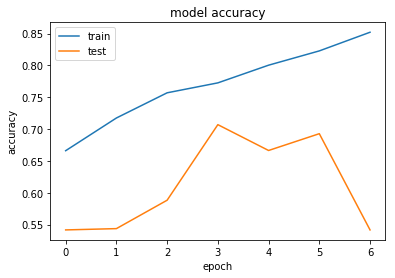

In [18]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig("/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/model_accuracy.pdf")
plt.show()

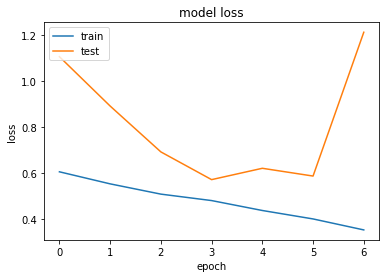

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig("/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/model_loss.pdf")
plt.show()


# Load last weights saved

In [20]:
model.load_weights('weights_No_data_augumentation.hdf5')

In [21]:
import sklearn
import itertools
from sklearn.metrics import confusion_matrix
dict_characters = { 1: 'Pneumothorax Observed', 0: 'No Pneumothorax Observed'}#['Infiltration Observed', 'No Infiltration Observed']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',fontsize=20,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=17)
    plt.yticks(tick_marks, classes,fontsize=17)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black", fontsize=20)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

In [22]:
a=X_train
b=y_train
c=X_valtest
d=y_valtest
Y_pred = model.predict(X_valtest)
Y_pred_classes = np.argmax(Y_pred,axis=1) 

In [23]:
model.evaluate(X_valtest,y_valtest)

1972/1972 [==============================] - 29s 15ms/step


[0.56090202849003168, 0.71247464503042601]

# Check the classification report:

In [24]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_valtest,axis=1), Y_pred_classes, target_names=list(dict_characters.values())))


                          precision    recall  f1-score   support

No Pneumothorax Observed       0.67      0.76      0.71       911
   Pneumothorax Observed       0.76      0.67      0.72      1061

             avg / total       0.72      0.71      0.71      1972



In [25]:
cnf_matrix = confusion_matrix(np.argmax(y_valtest, axis=1), Y_pred_classes)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[691 220]
 [347 714]]


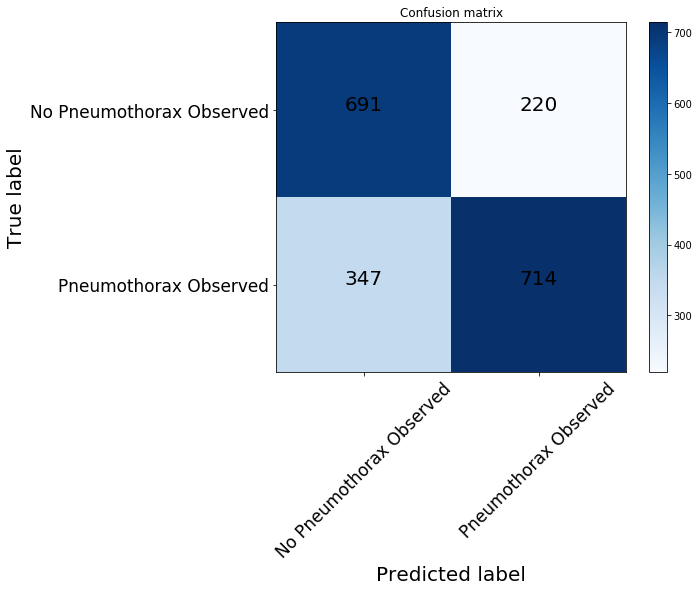

In [26]:
# Plot non-normalized confusion matrix
plt.figure(figsize=[10,8])
plot_confusion_matrix(cnf_matrix, classes=list(dict_characters.values()),
                      title='Confusion matrix')
#plt.savefig("/home/felipe/Dropbox/ML_diagnostics/draft/Felipe_notes/fig/confusion_matrix_Infiltration.pdf")
plt.show()

# We can see that the model can fairly predict wether the X-ray image does not have pneumothorax, but the model is not so great to diagnostic the pneumothorax cases.

Normalized confusion matrix
[[ 0.76  0.24]
 [ 0.33  0.67]]


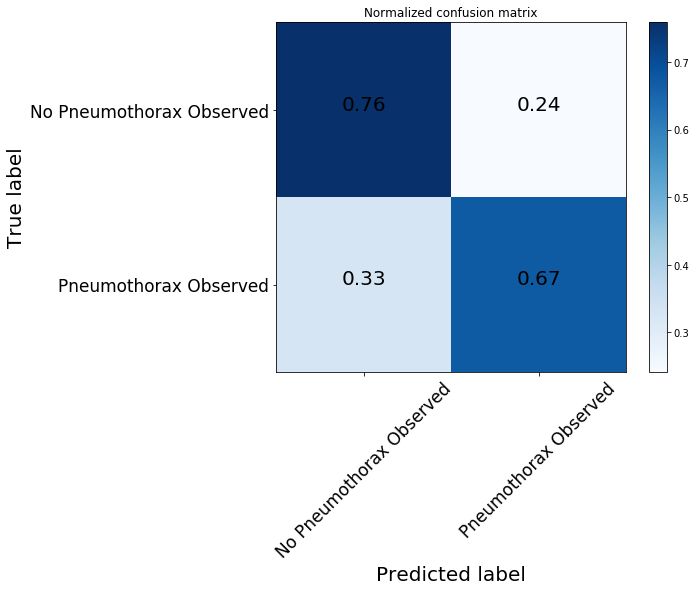

In [27]:
plt.figure(figsize=[10,8])
plot_confusion_matrix(cnf_matrix, classes=dict_characters.values(), normalize=True,
                      title='Normalized confusion matrix', fontsize=20)

plt.savefig("figs/norm_CM_no_data_aug.pdf")
plt.show()

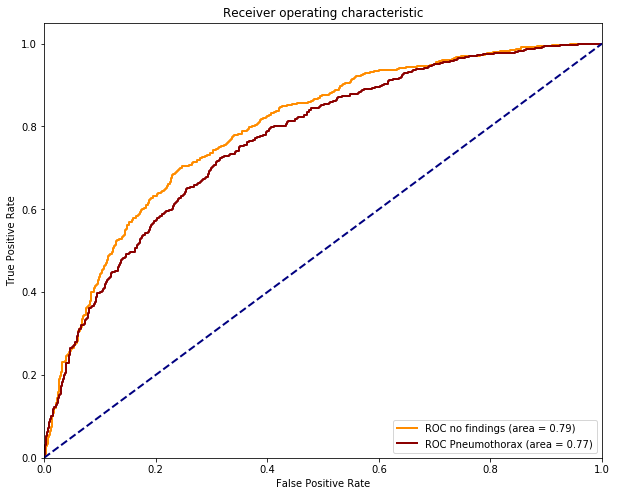

In [28]:
from sklearn.metrics import roc_curve, auc

fpr0, tpr0, thresholds0 = roc_curve(y_valtest[:,0], Y_pred[:,0])
fpr1, tpr1, thresholds1 = roc_curve(y_valtest[:,1], Y_pred[:,1])
roc_auc0 = auc(fpr0, tpr0)
roc_auc1 = auc(fpr1, tpr1)

plt.figure(figsize=[10,8])
lw = 2
plt.plot(fpr0, tpr0, color='darkorange',
         lw=lw, label='ROC no findings (area = %0.2f)'%(roc_auc0))
plt.plot(fpr1, tpr1, color='darkred',
         lw=lw, label='ROC Pneumothorax (area = %0.2f)'%(roc_auc1))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('figs/ROC_no_data_aug.pdf')
plt.show()

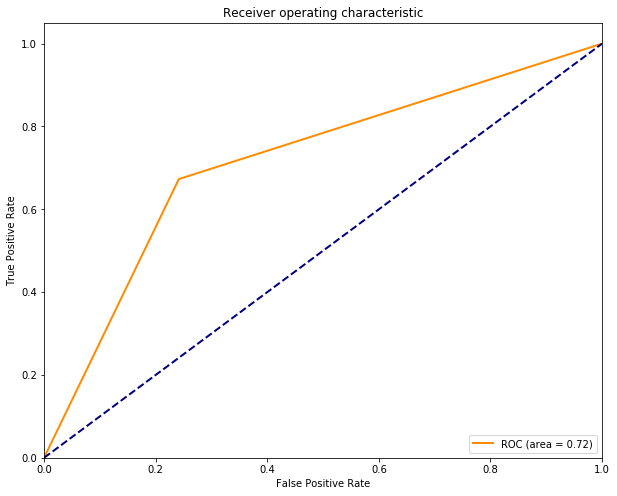

In [29]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(np.argmax(y_valtest,axis=1), Y_pred_classes)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[10,8])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.savefig('figs/ROC_no_data_aug_avg.pdf')
plt.legend(loc="lower right")
plt.show()

In [30]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score


In [31]:
precision0, recall0, thresholds0 = precision_recall_curve(y_valtest[:,0], Y_pred[:,0])
precision1, recall1, thresholds1 = precision_recall_curve(y_valtest[:,1], Y_pred[:,1])

In [32]:
from sklearn.metrics import average_precision_score
average_precision0 = average_precision_score(y_valtest[:,0], Y_pred[:,0])
average_precision1 = average_precision_score(y_valtest[:,1], Y_pred[:,1])

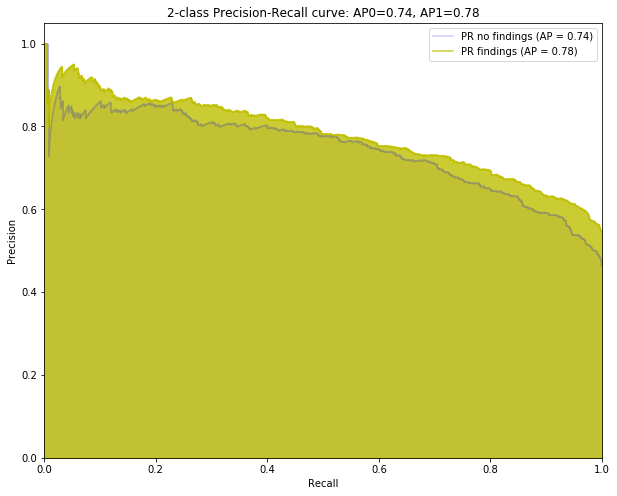

In [33]:
plt.figure(figsize=[10,8])
plt.step(recall0, precision0, color='b', alpha=0.2,
         where='post',label='PR no findings (AP = %0.2f)'%(average_precision0))
plt.fill_between(recall0, precision0, step='post', alpha=0.2,
                 color='b')
plt.step(recall1, precision1, color='y', alpha=0.8,
         where='post',label='PR findings (AP = %0.2f)'%(average_precision1))
plt.fill_between(recall1, precision1, step='post', alpha=0.8,
                 color='y')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP0={0:0.2f}, AP1={1:0.2f}'.format(
          average_precision0,average_precision1))
plt.legend(loc="best")
plt.savefig('figs/PR_no_data_aug.pdf')
plt.show()

In [35]:
precision, recall, thresholds = precision_recall_curve(np.argmax(y_valtest, axis=1), Y_pred_classes)
average_precision = average_precision_score(np.argmax(y_valtest, axis=1), Y_pred_classes)

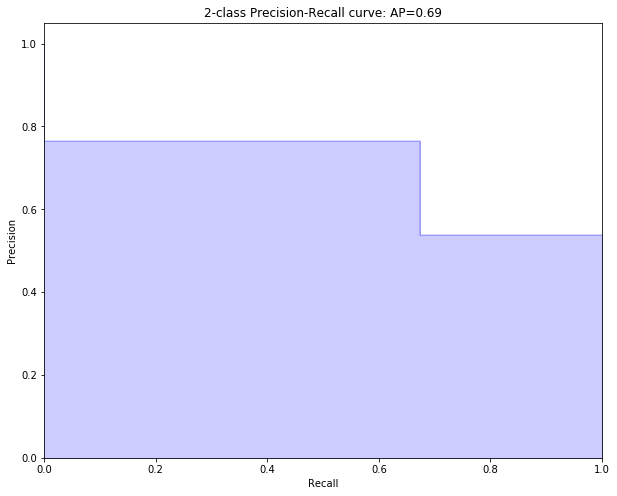

In [36]:
plt.figure(figsize=[10,8])
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.savefig('figs/PR_no_data_aug_avg.pdf')
plt.show()